In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from pathlib import Path
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

# load env variables, for data path
dotenv_path = Path().absolute() / '.env'
if dotenv_path.exists():
    load_dotenv(dotenv_path)
    
from covid_xrays_model import config

In [2]:
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, top_percent, size):
    img = cv2.imread(filepath)
    img = crop_top(img, percent=top_percent)
    img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

def random_ratio_resize(img, prob=0.3, delta=0.1):
    if np.random.rand() >= prob:
        return img
    ratio = img.shape[0] / img.shape[1]
    ratio = np.random.uniform(max(ratio - delta, 0.01), ratio + delta)

    if ratio * img.shape[1] <= img.shape[1]:
        size = (int(img.shape[1] * ratio), img.shape[1])
    else:
        size = (img.shape[0], int(img.shape[0] / ratio))

    dh = img.shape[0] - size[1]
    top, bot = dh // 2, dh - dh // 2
    dw = img.shape[1] - size[0]
    left, right = dw // 2, dw - dw // 2

    if size[0] > 480 or size[1] > 480:
        print(img.shape, size, ratio)

    img = cv2.resize(img, size)
    img = cv2.copyMakeBorder(img, top, bot, left, right, cv2.BORDER_CONSTANT,
                             (0, 0, 0))

    if img.shape[0] != 480 or img.shape[1] != 480:
        raise ValueError(img.shape, size)
    return img

_augmentation_transform = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=(0.9, 1.1),
    zoom_range=(0.85, 1.15),
    fill_mode='constant',
    cval=0.,
)

def apply_augmentation(img):
    img = random_ratio_resize(img)
    img = _augmentation_transform.random_transform(img)
    return img

def _process_csv_file(file):
    with open(file, 'r') as fr:
        files = fr.readlines()
    return files


In [3]:
class BalanceCovidDataset(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(
            self,
            data_dir,
            csv_file,
            is_training=True,
            batch_size=8,
            input_shape=(224, 224),
            n_classes=3,
            num_channels=3,
            mapping={
                'normal': 0,
                'pneumonia': 1,
                'COVID-19': 2
            },
            shuffle=True,
            augmentation=apply_augmentation,
            covid_percent=0.3,
            class_weights=[1., 1., 6.],
            top_percent=0.08
    ):
        'Initialization'
        self.datadir = data_dir
        self.dataset = _process_csv_file(csv_file)
        self.is_training = is_training
        self.batch_size = batch_size
        self.N = len(self.dataset)
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.num_channels = num_channels
        self.mapping = mapping
        self.shuffle = True
        self.covid_percent = covid_percent
        self.class_weights = class_weights
        self.n = 0
#         self.augmentation = augmentation
        self.top_percent = top_percent

        datasets = {'normal': [], 'pneumonia': [], 'COVID-19': []}
        for l in self.dataset:
            datasets[l.split()[2]].append(l)
        self.datasets = [
            datasets['normal'] + datasets['pneumonia'],
            datasets['COVID-19'],
        ]
        print(len(self.datasets[0]), len(self.datasets[1]))

        self.on_epoch_end()

    def __next__(self):
        # Get one batch of data
        batch_x, batch_y, weights = self.__getitem__(self.n)
        # Batch index
        self.n += 1

        # If we have processed the entire dataset then
        if self.n >= self.__len__():
            self.on_epoch_end
            self.n = 0

        return batch_x, batch_y, weights

    def __len__(self):
        return int(np.ceil(len(self.datasets[0]) / float(self.batch_size)))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            for v in self.datasets:
                np.random.shuffle(v)

    def __getitem__(self, idx):
        batch_x, batch_y = np.zeros(
            (self.batch_size, *self.input_shape,
             self.num_channels)), np.zeros(self.batch_size)

        batch_files = self.datasets[0][idx * self.batch_size:(idx + 1) *
                                       self.batch_size]

        # upsample covid cases
        covid_size = max(int(len(batch_files) * self.covid_percent), 1)
        covid_inds = np.random.choice(np.arange(len(batch_files)),
                                      size=covid_size,
                                      replace=False)
        covid_files = np.random.choice(self.datasets[1],
                                       size=covid_size,
                                       replace=False)
        for i in range(covid_size):
            batch_files[covid_inds[i]] = covid_files[i]

        for i in range(len(batch_files)):
            sample = batch_files[i].split()

            if self.is_training:
                folder = 'train'
            else:
                folder = 'test'

            x = process_image_file(os.path.join(self.datadir, folder, sample[1]),
                                   self.top_percent,
                                   self.input_shape[0])

            if self.is_training and hasattr(self, 'augmentation'):
                x = self.augmentation(x)

            x = x.astype('float32') / 255.0
            y = self.mapping[sample[2]]

            batch_x[i] = x
            batch_y[i] = y

        class_weights = self.class_weights
        weights = np.take(class_weights, batch_y.astype('int64'))

        return batch_x, keras.utils.to_categorical(batch_y, num_classes=self.n_classes), weights

In [6]:
# Parameters
batch_size = 8
# image dim (input_size X input_size)
input_size = 200
covid_percent = 0.3
covid_weight = 4
top_percent = 0.08


with open(config.TRAIN_FILE) as f:
    trainfiles = f.readlines()
with open(config.TEST_FILE) as f:
    testfiles = f.readlines()

generator = BalanceCovidDataset(data_dir=config.PROCESSED_DATA_DIR,
                                csv_file=config.TRAIN_FILE,
                                batch_size=batch_size,
                                input_shape=(input_size, input_size),
                                covid_percent=covid_percent,
                                class_weights=[1., 1., covid_weight],
                                top_percent=top_percent)


13425 398


In [7]:
x, y, w = next(generator)
len(generator)

1679

In [8]:
from time import time

data = []
t1 = time()
for i in range(100):
    data.append(next(generator))
print(f'Time: {time()-t1} sec')

Time: 12.467386484146118 sec


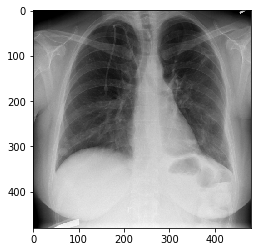

In [77]:
plt.imshow(x[0])

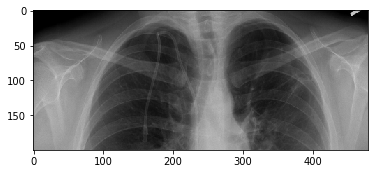

In [76]:
plt.imshow(x[0, 0:200, :])

In [85]:
x[0].shape

(480, 480, 3)

In [28]:
y

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [29]:
w

array([1., 1., 1., 1., 4., 1., 1., 4.])

In [111]:
image_file = '/home/doaa/Git/covid_xrays/data/processed/test_original.jpg'

size = 100

# img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

img = crop_top(img, percent=0.4)
# img = central_crop(img)
img = cv2.resize(img, (size, size))
    

In [112]:
img.shape

(100, 100)

In [50]:
cv2.imwrite('/home/doaa/Git/covid_xrays/data/processed/test.jpg', img)

True

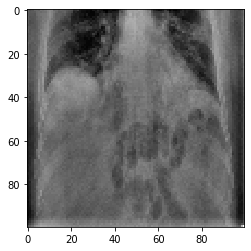

In [113]:
plt.imshow(img, cmap='gray')

In [106]:
x

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [105]:
img.shape

(100, 100)

In [99]:
a = img.reshape(-1, 100, 100, 1)

In [100]:
a.shape

(3, 100, 100, 1)

In [101]:
a

array([[[[104],
         [104],
         [104],
         ...,
         [ 56],
         [ 56],
         [ 41]],

        [[ 41],
         [ 41],
         [ 37],
         ...,
         [ 24],
         [ 38],
         [ 38]],

        [[ 38],
         [ 24],
         [ 24],
         ...,
         [129],
         [129],
         [129]],

        ...,

        [[105],
         [105],
         [104],
         ...,
         [139],
         [137],
         [137]],

        [[137],
         [148],
         [148],
         ...,
         [109],
         [109],
         [109]],

        [[ 97],
         [ 97],
         [ 97],
         ...,
         [110],
         [110],
         [108]]],


       [[[108],
         [108],
         [101],
         ...,
         [150],
         [133],
         [133]],

        [[133],
         [150],
         [150],
         ...,
         [106],
         [106],
         [106]],

        [[ 93],
         [ 93],
         [ 93],
         ...,
         [125],
         [

# FASTAI model

In [1]:
from fastai.vision import *
from fastai.vision import models
import pandas as pd

In [2]:
labels = pd.read_csv('/home/doaa/Git/covid_xrays/data/processed/labels_full.csv')

classes = ['pneumonia', 'normal', 'COVID-19']
ds_types = ['train', 'test']
size = 300
selected = []
for c in classes:
    for t in ds_types:
        selected.extend(labels[(labels.label == c) & (labels.ds_type == t)][:size].values.tolist())

subset = pd.DataFrame(selected, columns=labels.columns)
subset[['name', 'label']].to_csv('/home/doaa/Git/covid_xrays/data/processed/labels.csv', index=False)

In [6]:
tfms = get_transforms(do_flip=False,
#                       flip_vert=True, 
#                       max_lighting=0.1, max_zoom=1.05, max_warp=0.
                     )

data = ImageDataBunch.from_csv('/home/doaa/Git/covid_xrays/data/processed/', ds_tfms=tfms, size=420)
data.normalize()


ImageDataBunch;

Train: LabelList (1280 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Valid: LabelList (320 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Test: None

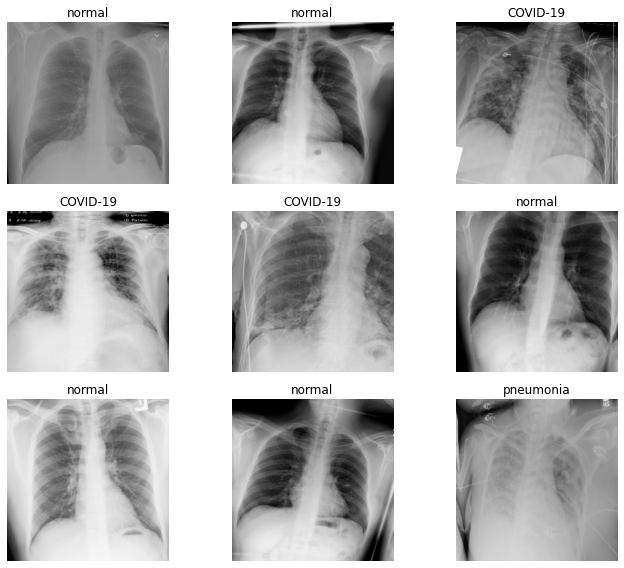

In [44]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Train)


In [10]:
# data.train_ds
data.classes, len(data.train_ds), len(data.valid_ds), data.c

(['COVID-19', 'normal', 'pneumonia'], 1280, 320, 3)

In [8]:
data

ImageDataBunch;

Train: LabelList (1280 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Valid: LabelList (320 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Test: None

In [19]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (1280 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Valid: LabelList (320 items)
x: ImageList
Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420),Image (3, 420, 420)
y: CategoryList
pneumonia,pneumonia,pneumonia,pneumonia,pneumonia
Path: /home/doaa/Git/covid_xrays/data/processed;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64,

In [45]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)


In [46]:
learn.fit(4)
# learn.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.555451,7.112807,0.408333,02:11
1,1.293045,2.967435,0.508333,03:07
2,1.134560,2.029494,0.616667,02:38
3,1.025625,1.657887,0.608333,01:52


In [47]:
# learn.model.parameters

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


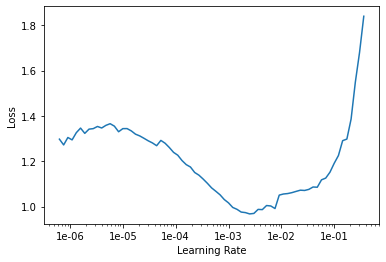

In [12]:
learn.freeze()
learn.fit_one_cycle(4)


learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

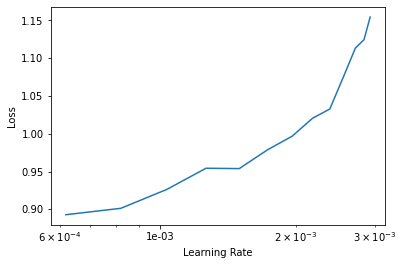

In [28]:
learn.recorder.plot(return_fig=True).savefig('figures/learning.png', dpi=200)


In [14]:
# choose slice from previous plot
learn.fit_one_cycle(4, max_lr=slice(3e-4, 3e-3))
# save model

epoch,train_loss,valid_loss,accuracy,time
0,1.271826,1.037335,0.633333,00:21
1,1.077190,2.157099,0.583333,00:20
2,0.926484,1.247535,0.658333,00:21
3,0.792892,0.820401,0.750000,00:21


# Load model

In [8]:
from covid_xrays_model.processing.data_management import load_saved_learner, load_dataset
from fastai.vision import *

In [2]:
learn = load_saved_learner(with_focal_loss=False, with_oversampling=True, sample_size=5000)
data = load_dataset(sample_size=5000)
learn.data = data

In [3]:
learn.show_results()

RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(return_fig=True).savefig('figures/confusion_matrix.png', dpi=200)


RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

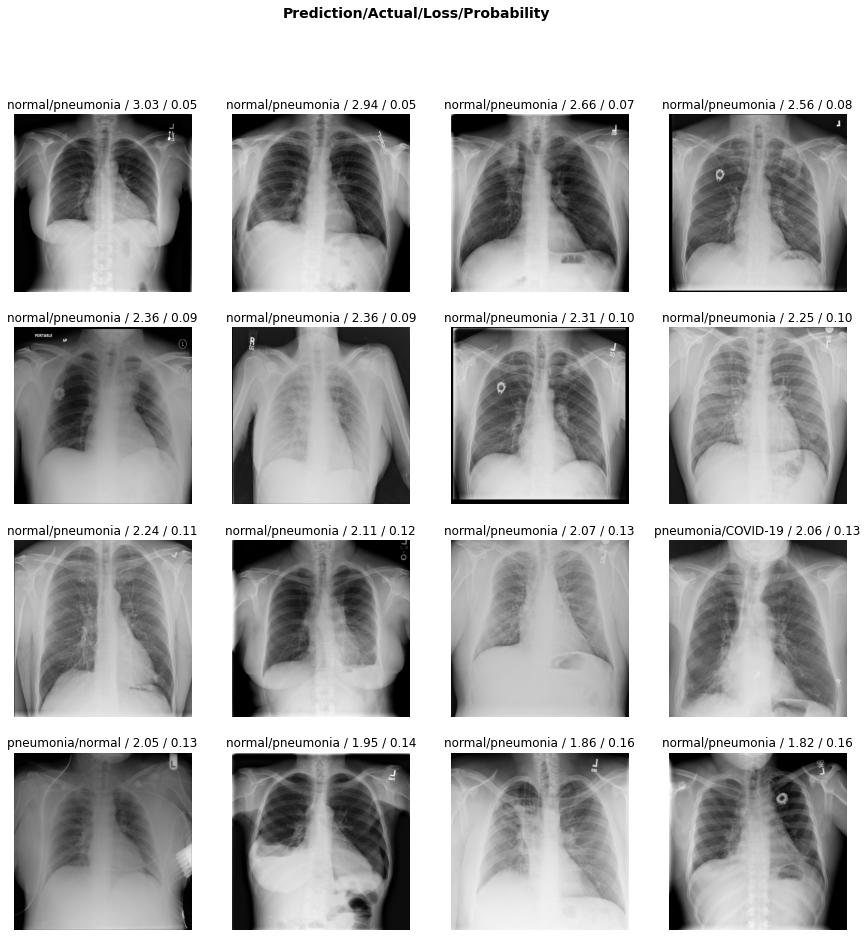

In [71]:
interp.plot_top_losses(16, largest=True, figsize=(15, 15))

In [72]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [73]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace=True)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace=True)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, mom

In [64]:
learn = load_learner('/home/doaa/Git/covid_xrays/covid_xrays_model/covid_xrays_model/trained_models/', 'covid_xrays_model_output_v.pkl')

In [67]:
# learn.show_results(rows=3, figsize=(12,15))

In [12]:
pred = learn.predict(data.train_ds[0][0])
pred

(Category tensor(0), tensor(0), tensor([9.0441e-01, 2.2937e-05, 9.5564e-02]))

In [13]:
print(pred[0].obj, '-------', pred[0].data, '//', pred[1], '//', pred[2])

COVID-19 ------- tensor(0) // tensor(0) // tensor([9.0441e-01, 2.2937e-05, 9.5564e-02])


In [14]:
{k:float(v) for k, v in zip(learn.data.classes, pred[2])}

{'COVID-19': 0.9044130444526672,
 'normal': 2.2936616005608812e-05,
 'pneumonia': 0.09556407481431961}

In [15]:
learn.data.classes


['COVID-19', 'normal', 'pneumonia']

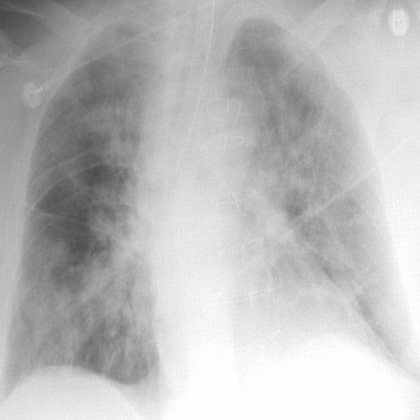

In [16]:
data.train_ds[0][0]


In [17]:
data.train_ds[0][1]


Category 2

In [18]:
print(data.train_ds.y[0].obj, '----', data.train_ds.y[0].data)

pneumonia ---- 2


In [3]:
labels.groupby(['ds_type', 'label']).count()

patient  name  dataset
ds_type label                            
test    COVID-19       100   100      100
        normal         885   885      885
        pneumonia      594   594      594
train   COVID-19       398   398      398
        normal        7966  7966     7966
        pneumonia     5459  5459     5459

In [4]:
labels.groupby('ds_type').count()

,patient,name,label,dataset
ds_type,,,,
test,1579,1579,1579,1579
train,13823,13823,13823,13823


In [5]:
labels.groupby('label').count()

,patient,name,dataset,ds_type
label,,,,
COVID-19,498,498,498,498
normal,8851,8851,8851,8851
pneumonia,6053,6053,6053,6053


In [6]:
labels.groupby('label').count().sum()

patient    15402
name       15402
dataset    15402
ds_type    15402
dtype: int64